In [37]:
import pandas as pd
import numpy as np
import re
import folium
import map
import json
import matplotlib.pyplot as plt
import math
import import_ipynb
from birthrate_col_graph import *
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['font.family']=['Malgun Gothic']
# rcParams['font.family']=['AppleGothic']
rcParams['axes.unicode_minus']=False

fertility = pd.read_csv('project_data/합계출산.csv', encoding='utf-8')
fertility.columns = ['합계출산;'+i for i in fertility.columns]
hdi = pd.read_csv('project_data/인간개발지수.csv',encoding='utf-8', header=[0,1])
hdi.columns = [';'.join(i) for i in hdi.columns]
hdi['국가별;국가별'] = hdi['국가별;국가별'].apply(lambda x: x.strip())
hdi.iloc[:,-1] = hdi.iloc[:,-1].str.replace(',','') # comma문제 해결

gdp = pd.read_csv('project_data/국민소득.csv', encoding='utf-8', header=[0,1])
gdp.columns = [';'.join(i) for i in gdp.columns]

urban = pd.read_csv('project_data/도시화율.csv', encoding='utf-8')
urban.columns = ['도시화율;'+i for i in urban.columns]

pop = pd.read_csv('project_data/인구_동향.csv', encoding='utf-8', header=[0,1])
pop.columns = [';'.join(i) for i in pop.columns]

action_man = pd.read_excel('project_data/경제활동참여율(남).xlsx').drop(columns='대륙')
action_woman = pd.read_excel('project_data/경제활동참여율(여).xlsx').drop(columns='대륙')
action_man = action_man.rename(columns = {'국가':'국가별;국가별',
                                          '경제활동참여율;2020':'경제활동참여율;남자'})
action_woman = action_woman.rename(columns = {'국가':'국가별;국가별',
                                              '경제활동참여율;2020':'경제활동참여율;여자'})
edu = pd.read_excel('project_data/교육정도별_취학률.xlsx', header=[0,1])
edu[('국가별','국가별')] = np.repeat(edu[('국가별','국가별')]\
                               [edu[('국가별','국가별')].isna()==False].values,
                               3)
edu[('국가별','국가별')] = edu[('국가별','국가별')].apply(lambda x: x.strip())
edu.columns = [';'.join(i) for i in edu.columns]
edu = pd.concat([edu.pivot(values = i, columns = '성별;성별', index = '국가별;국가별')
                for i in edu.columns[2:]], keys = [i for i in edu.columns[2:]],
                axis=1)
edu = edu.replace('-',np.nan)
def all_na(df_col):
    not_na = df_col[df_col.isna()==False]
    if len(not_na)>0:
        return not_na.iloc[0]
    else:
        return np.nan
for i in range(4):
    first_name = edu.columns[9*i][0].split(';')[0]
    for j in range(3):
        last_name = edu.columns[9*i+j][1]
        edu[(first_name,last_name)] = edu.iloc[:,9*i+j:9*(i+1)+j:3].apply(all_na,
                                                                          axis=1)
edu = edu.iloc[:,-12:]
edu.columns = [';'.join(i) for i in edu.columns]
edu[edu.index.name] = edu.index
edu.index = range(len(edu))
merged_df = gdp.copy()
merged_df
for file in (fertility, urban, hdi, pop, edu, action_man, action_woman):
    try:
        merged_df = merged_df.merge(file,
                              'outer',
                              left_on = '국가;국가',
                              right_on = '국가별;국가별',
                              )
    except:
        merged_df = merged_df.merge(file,
                              'outer',
                              left_on = '국가;국가',
                              right_on = file.columns[file.columns.str.endswith('국가별')][0],
                              )
nation_column = merged_df[merged_df.columns[merged_df.columns.str.contains('국가(별|;)')]]
merged_df = merged_df.drop(
    columns = merged_df.columns[merged_df.columns.str.contains('국가(별|;)')])
merged_df['국가'] = nation_column.apply(lambda x: x[x.isna()==False].iloc[0], axis=1)
duplicate = merged_df['국가'].value_counts()[merged_df['국가'].value_counts()>1].index
rm_na_df = merged_df[merged_df['국가'].isin(duplicate)].\
                                groupby('국가').apply(lambda x: x.apply(all_na))
merged_df = merged_df.drop(index = merged_df[merged_df['국가'].isin(duplicate)].index)
final_data = pd.concat([merged_df,rm_na_df], axis=0)
final_data.set_index(['국가'], inplace=True)
final_data.replace('-',np.NaN, inplace = True)
#final_data.to_csv('210809자료합친파일.csv', encoding="utf-8-sig")
for col in final_data.columns:
    final_data[col] = final_data[col].apply(lambda data : data if pd.isna(data) else re.findall('[0-9.-]+',str(data))[0])
final_data = final_data.astype(float)
final_data.to_csv('210809자료합친파일.csv', encoding="utf-8-sig")

C:\Users\song\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [38]:
for col in final_data.columns:
    final_data[col] = final_data[col].apply(lambda data : data if pd.isna(data) else np.NaN if data =='-' else re.findall('[0-9.-]+',str(data))[0])
final_data = final_data.astype(float)
final_data

,2018;국내총생산(GDP $),2019;국내총생산(GDP $),합계출산;2015,합계출산;2020,도시화율;2020,평균교육기간(년);2018,1인당 GNI(구매력환산기준 2011) (달러);2018,2020;연간 인구증가율,2020;0~14세 인구 구성비,2020;15~64세 인구 구성비,...,초등교육;여자,초등교육;합계,중등교육;남자,중등교육;여자,중등교육;합계,고등교육;남자,고등교육;여자,고등교육;합계,경제활동참여율;남자,경제활동참여율;여자
국가,,,,,,,,,,,,,,,,,,,,,
아프가니스탄,1.835388e+10,1.929110e+10,5.45,4.56,26.0,3.9,1746.0,2.304,41.823,55.528,...,82.1,102.2,67.9,38.6,53.6,14.2,4.9,9.7,NaN,NaN
알바니아,1.514702e+10,1.528661e+10,1.71,1.62,62.1,10.1,12300.0,-0.578,17.236,68.060,...,108.9,107.0,95.8,94.7,95.3,45.7,69.8,57.4,64.392,46.603
알제리,1.754150e+11,1.711578e+11,2.96,3.05,73.7,8.0,13639.0,1.837,30.784,62.474,...,108.9,111.8,NaN,NaN,NaN,38.4,57.2,47.6,67.034,14.556
미국령사모아,6.410000e+08,6.380000e+08,NaN,NaN,NaN,NaN,NaN,-0.208,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
안도라,3.218316e+09,3.155065e+09,NaN,NaN,87.9,10.2,48641.0,0.154,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
오세아니아,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
유럽,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
지브롤터,NaN,NaN,NaN,NaN,100.0,NaN,NaN,-0.045,NaN,NaN,...,103.7,103.5,119.1,115.7,117.5,NaN,NaN,NaN,NaN,NaN


In [39]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, 아프가니스탄 to 프랑스령폴리네시아
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   2018;국내총생산(GDP $)                203 non-null    float64
 1   2019;국내총생산(GDP $)                197 non-null    float64
 2   합계출산;2015                        195 non-null    float64
 3   합계출산;2020                        195 non-null    float64
 4   도시화율;2020                        200 non-null    float64
 5   평균교육기간(년);2018                   188 non-null    float64
 6   1인당 GNI(구매력환산기준 2011) (달러);2018  190 non-null    float64
 7   2020;연간 인구증가율                    210 non-null    float64
 8   2020;0~14세 인구 구성비                191 non-null    float64
 9   2020;15~64세 인구 구성비               191 non-null    float64
 10  2020;65세이상 인구 구성비                191 non-null    float64
 11  학년전교육;남자                         139 non-null    float64
 12  학년전교육;여자        

In [40]:
with open ('countries_data.json', 'r', encoding='cp949') as file:
    countries_data = json.load(file)

final_data['국가명'] = final_data.index # index의 국가명을 column으로도 만들었습니다
above_mean_birthrate = final_data[final_data['합계출산;2020'] >= final_data['합계출산;2020'].mean()]
below_mean_birthrate = final_data[final_data['합계출산;2020'] < final_data['합계출산;2020'].mean()]

mean_birthrate_world_map = folium.Map(
    location = [38, 38], 
    tiles='CartoDB positron',
    zoom_start=2)


folium.Choropleth(geo_data = countries_data,
        data = above_mean_birthrate,
        columns = ['국가명','합계출산;2020'],
        key_on = 'properties.korname',
        fill_color = 'GnBu',
        fill_opacity=0.5,
        nan_fill_color = None,
#         fill_opacity="white",
        line_color = 'white',
        line_opacity = 0.4,
        legend_name = '2020합계출산률(평균 이상)',
        ).add_to(mean_birthrate_world_map)

folium.Choropleth(geo_data = countries_data,
        data = below_mean_birthrate,
        columns = ['국가명','합계출산;2020'],
        key_on = 'properties.korname',
        fill_color = 'RdPu',
        fill_opacity=0.5,
        nan_fill_color = None,
        line_color = 'white',
        line_opacity = 0.4,
        legend_name = '2020합계출산률(평균 이하)',
        ).add_to(mean_birthrate_world_map)

mean_birthrate_world_map.save('example_map.html')
# mean_birthrate_world_map

# 전세계 2020년 평균 출산율 이하 국가와 이상 국가 

In [41]:
mean_birthrate_world_map

# 출생율에 영향을 끼치는 요소 분석

# 1. GDP와 출산율 상관관계

In [42]:
gdp_birthrate_df = final_data[['2019;국내총생산(GDP $)','합계출산;2020','국가명']]
gdp_birthrate_df = gdp_birthrate_df[gdp_birthrate_df['국가명'] != '세계']
gdp_birthrate_df.sort_values('2019;국내총생산(GDP $)',ascending = False, inplace = True)
gdp_birthrate_df

,2019;국내총생산(GDP $),합계출산;2020,국가명
국가,,,
미국,2.143322e+13,1.78,미국
중국,1.427994e+13,1.69,중국
일본,5.064873e+12,1.37,일본
독일,3.861124e+12,1.59,독일
인도,2.870504e+12,2.24,인도
...,...,...,...
오세아니아,NaN,NaN,오세아니아
유럽,NaN,NaN,유럽
지브롤터,NaN,NaN,지브롤터


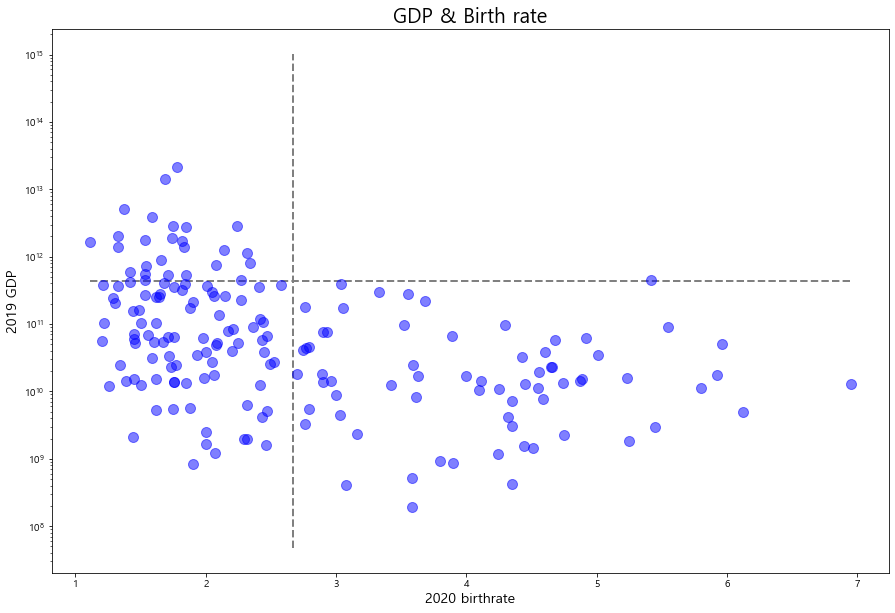

In [43]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot('합계출산;2020',
         '2019;국내총생산(GDP $)',
         data = gdp_birthrate_df, 
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='blue', 
         alpha=0.5)

# plt.scatter(gdp_birthrate_df['합계출산;2020'],gdp_birthrate_df['2019;국내총생산(GDP $)'])

plt.title('GDP & Birth rate', fontsize=20)
plt.xlabel('2020 birthrate', fontsize=14)
plt.ylabel('2019 GDP', fontsize=14)
plt.yscale('log')
plt.hlines(gdp_birthrate_df['2019;국내총생산(GDP $)'].mean(),
           gdp_birthrate_df['합계출산;2020'].min(),
           gdp_birthrate_df['합계출산;2020'].max(),
         color='gray',
         linestyle='--',
         linewidth = 2)
plt.vlines(gdp_birthrate_df['합계출산;2020'].mean(),
           gdp_birthrate_df['2019;국내총생산(GDP $)'].min(),
           gdp_birthrate_df['2019;국내총생산(GDP $)'].max()+1000000000000000,
         color='gray',
         linestyle='--',
         linewidth = 2)
# plt.ylim([0,gdp_birthrate_df['2019;국내총생산(GDP $)'].max()])
plt.show()



- GDP와 출생률 공분산

In [44]:
gdp_birthrate_df.cov()


,2019;국내총생산(GDP $),합계출산;2020
2019;국내총생산(GDP $),3.690562e+24,-4.293593e+11
합계출산;2020,-4.293593e+11,1.587771e+00


- GDP와 출생률 상관계수

In [45]:
gdp_birthrate_df.corr()

,2019;국내총생산(GDP $),합계출산;2020
2019;국내총생산(GDP $),1.000000,-0.166184
합계출산;2020,-0.166184,1.000000


In [69]:
city_birth_gh=makeDataframe('도시화율;2020')
edu_birth_gh=makeDataframe('평균교육기간(년);2018')
gni_birth_gh=makeDataframe('1인당 GNI(구매력환산기준 2011) (달러);2018')
improve_birth_gh=makeDataframe('2020;연간 인구증가율')
female_brith_gh = makeDataframe('경제활동참여율;여자')
age_brith_gh = makeDataframe()

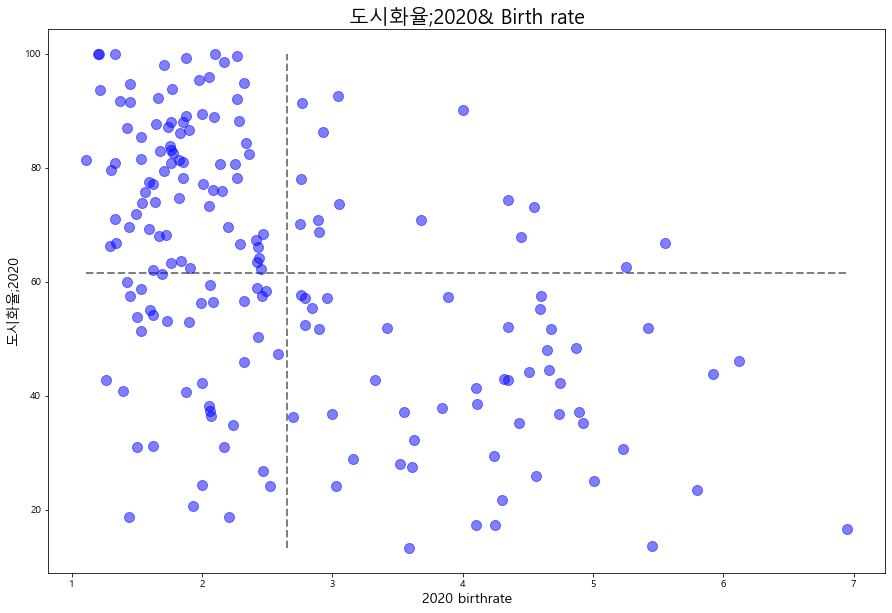

In [48]:
makeGraph(city_birth_gh,'도시화율;2020')

In [62]:
city_birth_gh.cov()

,도시화율;2020,합계출산;2020
도시화율;2020,532.042086,-14.730371
합계출산;2020,-14.730371,1.573973


In [63]:
city_birth_gh.corr()

,도시화율;2020,합계출산;2020
도시화율;2020,1.000000,-0.509028
합계출산;2020,-0.509028,1.000000


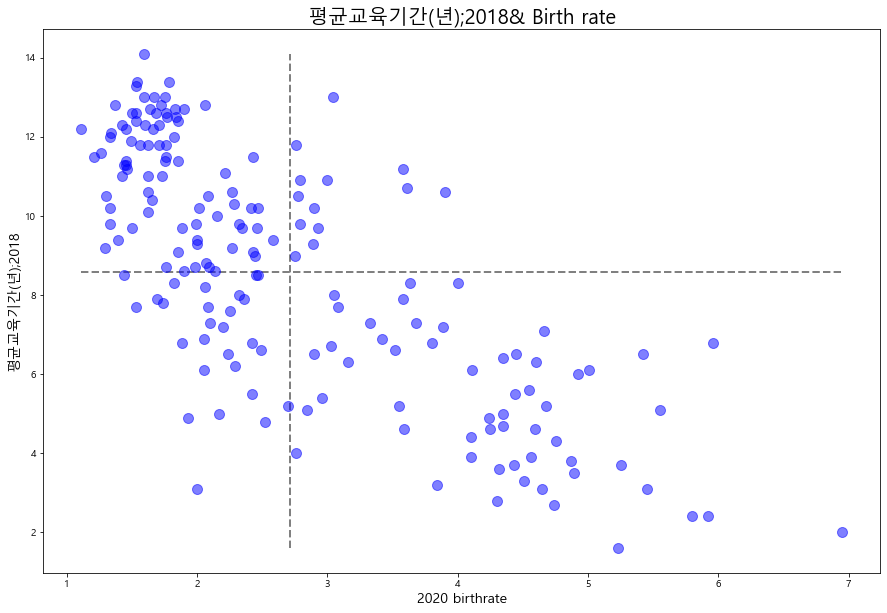

In [49]:
makeGraph(edu_birth_gh,'평균교육기간(년);2018')

In [64]:
edu_birth_gh.cov()

,평균교육기간(년);2018,합계출산;2020
평균교육기간(년);2018,9.647314,-2.972975
합계출산;2020,-2.972975,1.586992


In [66]:
edu_birth_gh.corr()

,평균교육기간(년);2018,합계출산;2020
평균교육기간(년);2018,1.000000,-0.759802
합계출산;2020,-0.759802,1.000000


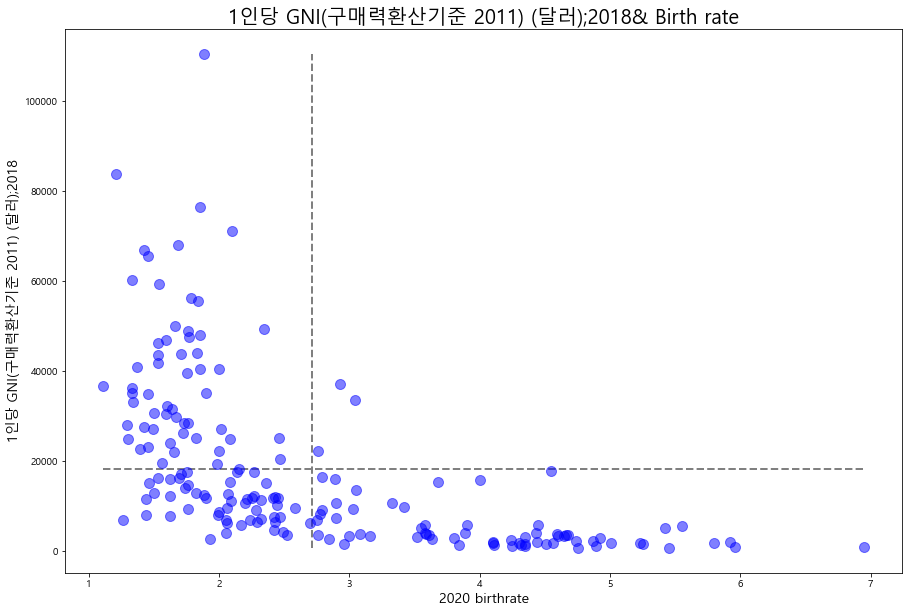

In [50]:
makeGraph(gni_birth_gh,'1인당 GNI(구매력환산기준 2011) (달러);2018')

In [67]:
gni_birth_gh.cov()

,1인당 GNI(구매력환산기준 2011) (달러);2018,합계출산;2020
1인당 GNI(구매력환산기준 2011) (달러);2018,3.625307e+08,-13733.856789
합계출산;2020,-1.373386e+04,1.586992


In [68]:
gni_birth_gh.corr()

,1인당 GNI(구매력환산기준 2011) (달러);2018,합계출산;2020
1인당 GNI(구매력환산기준 2011) (달러);2018,1.000000,-0.572576
합계출산;2020,-0.572576,1.000000


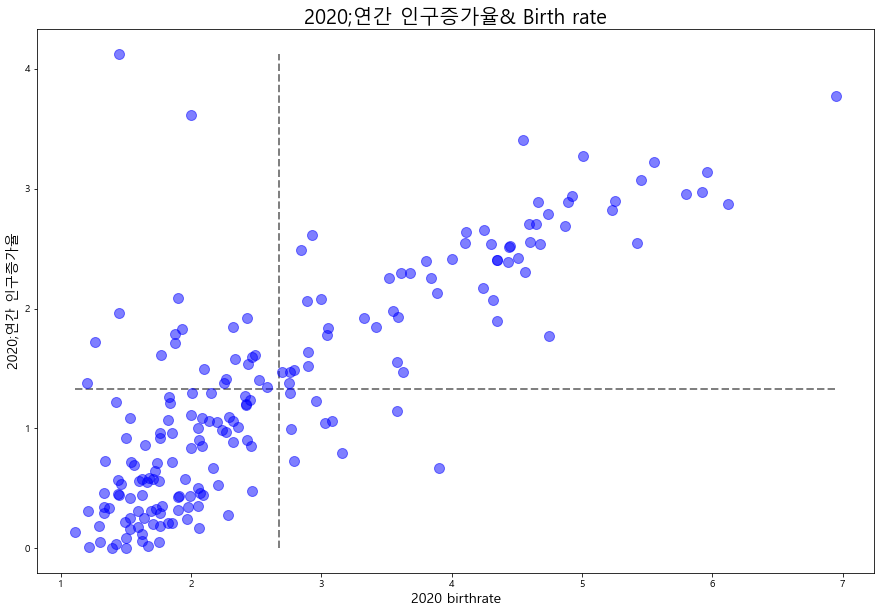

In [51]:
makeGraph(improve_birth_gh,'2020;연간 인구증가율')

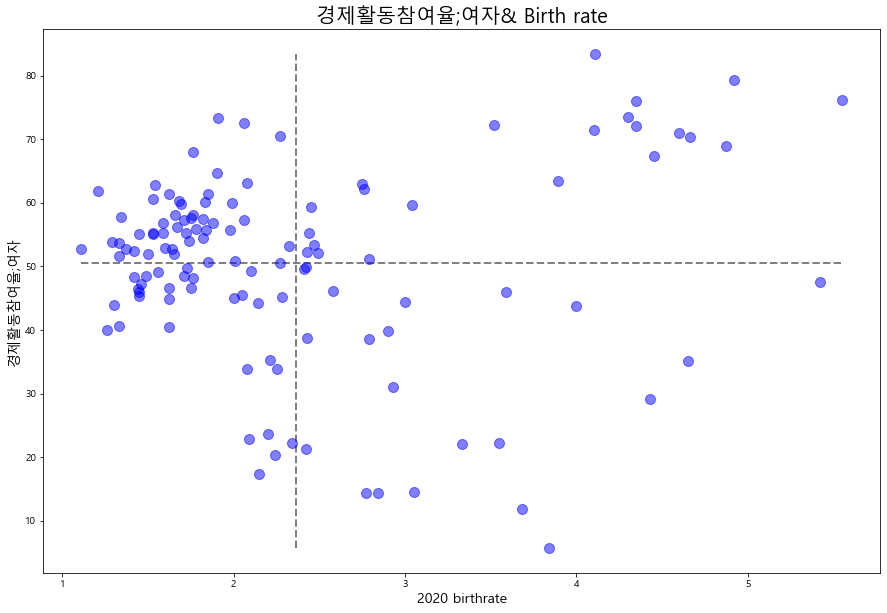

In [70]:
makeGraph(female_brith_gh,'경제활동참여율;여자')

In [71]:
female_brith_gh.cov()

,경제활동참여율;여자,합계출산;2020
경제활동참여율;여자,233.389116,1.314100
합계출산;2020,1.314100,1.063673


In [72]:
female_brith_gh.corr()

,경제활동참여율;여자,합계출산;2020
경제활동참여율;여자,1.000000,0.083403
합계출산;2020,0.083403,1.000000


In [52]:
#시간이 남는다면 자연증감이 아닌 사회적 증감도 하기위한 장치로 밑에 걸 해놓았습니다. 아직 작업 중...

- 인구대체수준(인구를 현상유지하는 데 필요한 출산율의 수준)은 선진국의 경우 2.1명으로 잡고 있다.(농협경제연구소)

In [53]:
maintain_birthrate_world_map = folium.Map(location = [38, 38], tiles='CartoDB positron',
    zoom_start=2)

below_maintain_birthrate = final_data[final_data['합계출산;2020'] > 2.1]

folium.Choropleth(geo_data = countries_data,
        data = below_maintain_birthrate,
        columns = ['국가명','합계출산;2020'],
        key_on = 'properties.korname',
        fill_color = 'GnBu',
        nan_fill_color = None,
        fill_opacity = 0.5,
        line_color = 'white',
        legend_name = '2020합계출산률(2.1 이하 국가)',
        ).add_to(maintain_birthrate_world_map)

# 출산율이 2.1 이상인 국가

In [54]:
maintain_birthrate_world_map

In [55]:
pop_incrate_world_map = folium.Map(location = [38, 38], tiles='CartoDB positron',
    zoom_start=2)

folium.Choropleth(geo_data = countries_data,
        data = final_data[final_data['2020;연간 인구증가율'] > 0],
        columns = ['국가명','2020;연간 인구증가율'],
        key_on = 'properties.korname',
        fill_color = 'YlGn',
        nan_fill_color = 'white',
        fill_opacity = 0.5,
        line_color = 'white',
        legend_name = '2020 국가별 인구 증가율',
        ).add_to(pop_incrate_world_map)

# 인구가 증가한 국가

In [56]:
pop_incrate_world_map

In [57]:
pop_decrate_world_map = folium.Map(location = [38, 38], tiles='CartoDB positron',
    zoom_start=2)

folium.Choropleth(geo_data = countries_data,
        data = final_data[final_data['2020;연간 인구증가율'] < 0],
        columns = ['국가명','2020;연간 인구증가율'],
        key_on = 'properties.korname',
        fill_color = 'OrRd',
        nan_fill_color = 'white',
        fill_opacity = 0.5,
        line_color = 'white',
        legend_name = '2020 국가별 인구 증가율',
        ).add_to(pop_decrate_world_map)

# 인구가 감소한 나라

In [58]:
pop_decrate_world_map

# 출산율이 2.1 미만임에도 인구가 증가한 나라

In [59]:
differ_pop_world_map = folium.Map(location = [38, 38], tiles='CartoDB positron',
    zoom_start=2)

folium.Choropleth(geo_data = countries_data,
        data = final_data[(final_data['2020;연간 인구증가율'] > 0) &(final_data['합계출산;2020'] < 2.1)],
        columns = ['국가명','2020;연간 인구증가율'],
        key_on = 'properties.korname',
        fill_color = 'GnBu',
        nan_fill_color = 'white',
        fill_opacity = 0.5,
        line_color = 'white',
        legend_name = '2020 국가별 인구 증가율',
        ).add_to(differ_pop_world_map)

In [60]:
differ_pop_world_map